In [1]:
import spacejam as sj
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys

## Optional Plotting Configs 

In [27]:
# relationship beteen time and step (N*h = T)
# h: timestep
# N: total number of steps
# T: total time

# Initial conditions
h = 0.01
N = 500
T = h*N
X = np.zeros(N)
X[0] = 1
t = np.arange(0, T, h)

# toy function
def f(x):
    f1 = -x
    return np.array([f1])

# analytic solution
def analytic(t): #t=np.arange(0, T=5, h=0.01)
    x = np.exp(-t)
    return x

# the X_test is the analytical result
X_test = analytic(t)

# run simulation for Adams-Moulton order 0
for n in range(N-1):
    X[n+1] = sj.integrators.amso(f, np.array([X[n]]), h=h, X_tol=1E-6, i_tol=0)

tol_0 = 0.0032 
diff_0 = np.abs(X[-1] - X_test[-1]) #X[-1]==0.009920974201040624, X_test[-1]==0.006805664492230543
diff_0

SystemExit: 
Sorry, spacejam did not converge for s=0 A-M method.
Try adjusting X_tol, i_tol, or using another integrator.

/Users/mango/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [33]:
import pytest

In [ ]:
pytest.as

In [4]:
sns.set_style('darkgrid')
sns.set_palette('colorblind')
%config InlineBackend.figure_format = 'retina'

# Astro Example

## Setup

In [247]:
from astropy import units as u
from astropy import constants as c

# constants
solMass   = (1 * u.solMass).cgs.value
solRad    = (1 * u.solRad).cgs.value
jupMass   = (1 * u.jupiterMass).cgs.value
jupRad    = (1 * u.jupiterRad).cgs.value
earthMass = (1 * u.earthMass).cgs.value
earthRad  = (1 * u.earthRad).cgs.value
G         = (1 * c.G).cgs.value
AU        = (1 * u.au).cgs.value
year      = (1 * u.year).cgs.value
day       = (1 * u.day).cgs.value
earth_v   = (30 * u.km/u.s).value
moon_v    = (1 * u.km/u.s).cgs.value

# mass ratio of companion to secondary
q              = 0.001
# primary
host_mass      = solMass
host_rad       = solRad
# secondary
scndry_mass    = 10*jupMass
scndry_rad     = 1.7*jupRad
scndry_x       = -0.01*AU
scndry_y       = 0.0
scndry_vx      = 0.0
scndry_vy      = -np.sqrt(G*host_mass/np.abs(scndry_x)) # assuming Keplerian for now
# companion
cmpn_mass      = q*scndry_mass
cmpn_rad       = 0.3*scndry_rad 
hill_sphere    = np.abs(scndry_x) * (scndry_mass / (3*host_mass))**(1/3)
cmpn_x         = scndry_x - 0.5 * hill_sphere
cmpn_y         = scndry_y
cmpn_vx        = 0.0 
cmpn_vy        = scndry_vy - np.sqrt(G*scndry_mass/(0.5 * hill_sphere))

m_1 = host_mass # host star
m_2 = scndry_mass #m_1 / 5000 # hot jupiter
m_3 = cmpn_mass  # companion

# m1: primary (hardcoded)
x_1  =  0.0
y_1  =  0.0
vx_1 =  0.0
vy_1 =  0.0

# m2: secondary
x_2  = scndry_x
y_2  = scndry_y # doesn't matter where it starts on y because of symmetry of system
vx_2 = scndry_vx
vy_2 = scndry_vy # assuming Keplerian for now

# m3: companion 
x_3  = cmpn_x
y_3  = cmpn_y 
vx_3 = cmpn_vx
vy_3 = cmpn_vy 

# characteristic timescale set by secondary's orbital timescale
T0 = 2*np.pi*np.sqrt(np.abs(scndry_x)**3/(G*m_1))
tmax  = 2.5*T0

uold_1 = np.array([x_1, y_1, vx_1, vy_1])
uold_2 = np.array([x_2, y_2, vx_2, vy_2])
uold_3 = np.array([x_3, y_3, vx_3, vy_3])

m1_coord = uold_1
m2_coord = uold_2
m3_coord = uold_3

r0 = np.sqrt( (uold_3[0] - uold_2[0])**2 + (uold_3[1] - uold_2[1])**2 )
v0 = np.sqrt(uold_3[2]**2 + uold_3[3]**2) 
f = -1
h = 10**(f) * r0 / v0
N = int(1.5*T0 / h) # number of steps to run sim, consistent with T0

# Store initial positions and velocities
uold_1 = np.array([x_1, y_1, vx_1, vy_1]) # star
uold_2 = np.array([x_2, y_2, vx_2, vy_2]) # exoplanet
uold_3 = np.array([x_3, y_3, vx_3, vy_3]) # exomoon

## Functions

In [219]:
def sho_func(x, y, vx, vy, uold_b=None, mb=0, uold_c=None, mc=0):
    # position and velocity
    r_a = np.array([x, y])
    v_a = np.array([vx, vy])
    
    r_b = uold_b[:2]
    r_c = uold_c[:2] 
    # position vector pointing from one of the two masses to m_i
    d_ab = np.linalg.norm(r_b - r_a)
    d_ac = np.linalg.norm(r_c - r_a)

    # calulating accelerations
    gx = G*mb/d_ab**3 * (r_b[0] - x) + (G*mc/d_ac**3) * (r_c[0] - x)
    gy = G*mb/d_ab**3 * (r_b[1] - y) + (G*mc/d_ac**3) * (r_c[1] - y)
    #derivs = np.ndarray(4)
    #derivs[:2] = v_i
    #derivs[2:] = g  
    f1 = vx
    f2 = vy
    f3 = gx
    f4 = gy
    return np.array([f1, f2, f3, f4])

## Sim

### s = 0

In [273]:
X_1 = np.zeros((N, uold_1.size))
X_1[0] = uold_1
X_2 = np.zeros((N, uold_2.size))
X_2[0] = uold_2
X_3 = np.zeros((N, uold_3.size))
X_3[0] = uold_3

for n in range(N-1): 
    kwargs_1 = {'uold_b': X_2[n], 'mb': m_2, 'uold_c': X_3[n], 'mc': m_3}
    X_1[n+1] = sj.integrators.amso(sho_func, X_1[n], h=h, kwargs=kwargs_1)
    
    kwargs_2 = {'uold_b': X_1[n], 'mb': m_1, 'uold_c': X_3[n], 'mc': m_3}
    X_2[n+1] = sj.integrators.amso(sho_func, X_2[n], h=h, kwargs=kwargs_2)
    
    kwargs_3 = {'uold_b': X_1[n], 'mb': m_1, 'uold_c': X_2[n], 'mc': m_2}
    X_3[n+1] = sj.integrators.amso(sho_func, X_3[n], h=h, kwargs=kwargs_3)
    
    #if X_1[n+1] is None or X_2[n+1] is None or X_3[n+1] is None:
    #    print ('System did not converge')
    #    break

SystemExit: 
Sorry, spacejam did not converge for s=0 A-M method.
Try adjusting X_tol, i_tol, or using another integrator.

/Users/mango/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### s = 1

In [271]:
X_1 = np.zeros((N, uold_1.size))
X_1[0] = uold_1
X_2 = np.zeros((N, uold_2.size))
X_2[0] = uold_2
X_3 = np.zeros((N, uold_3.size))
X_3[0] = uold_3

for n in range(N-1): 
    kwargs_1 = {'uold_b': X_2[n], 'mb': m_2, 'uold_c': X_3[n], 'mc': m_3}
    X_1[n+1] = sj.integrators.amsi(sho_func, X_1[n], h=h, kwargs=kwargs_1)
    
    kwargs_2 = {'uold_b': X_1[n], 'mb': m_1, 'uold_c': X_3[n], 'mc': m_3}
    X_2[n+1] = sj.integrators.amsi(sho_func, X_2[n], h=h, kwargs=kwargs_2)
    
    kwargs_3 = {'uold_b': X_1[n], 'mb': m_1, 'uold_c': X_2[n], 'mc': m_2}
    X_3[n+1] = sj.integrators.amsi(sho_func, X_3[n], h=h, kwargs=kwargs_3)
    
    if X_1[n+1] is None or X_2[n+1] is None or X_3[n+1] is None:
        print('did not converge')
        break

### s = 2

In [226]:
X_1 = np.zeros((N, uold_1.size))
X_1[0] = uold_1
X_2 = np.zeros((N, uold_2.size))
X_2[0] = uold_2
X_3 = np.zeros((N, uold_3.size))
X_3[0] = uold_3

kwargs_1 = {'uold_b': X_2[0], 'mb': m_2, 'uold_c': X_3[0], 'mc': m_3}
ad = sj.AutoDiff(sho_func, X_1[0], kwargs=kwargs_1)
X_1[1] = X_1[0] + h*ad.r.flatten() 

kwargs_2 = {'uold_b': X_1[0], 'mb': m_1, 'uold_c': X_3[0], 'mc': m_3}
ad = sj.AutoDiff(sho_func, X_2[0], kwargs=kwargs_2)
X_2[1] = X_2[0] + h*ad.r.flatten() 

kwargs_3 = {'uold_b': X_1[0], 'mb': m_1, 'uold_c': X_2[0], 'mc': m_2}
ad = sj.AutoDiff(sho_func, X_3[0], kwargs=kwargs_3)
X_3[1] = X_3[0] + h*ad.r.flatten() 

for n in range(1, N-1): 
    kwargs_1 = {'uold_b': X_2[n], 'mb': m_2, 'uold_c': X_3[n], 'mc': m_3}
    X_1[n+1] = sj.integrators.amsii(sho_func, X_1[n], X_1[n-1], 
                                    h=h, kwargs=kwargs_1)
    
    kwargs_2 = {'uold_b': X_1[n], 'mb': m_1, 'uold_c': X_3[n], 'mc': m_3}
    X_2[n+1] = sj.integrators.amsii(sho_func, X_2[n], X_2[n-1], 
                                    h=h, kwargs=kwargs_2)
    
    kwargs_3 = {'uold_b': X_1[n], 'mb': m_1, 'uold_c': X_2[n], 'mc': m_2}
    X_3[n+1] = sj.integrators.amsii(sho_func, X_3[n], X_3[n-1], 
                                    h=h, kwargs=kwargs_3)
    
    if X_1[n+1] is None or X_2[n+1] is None or X_3[n+1] is None:
        break

## Viz

### Image

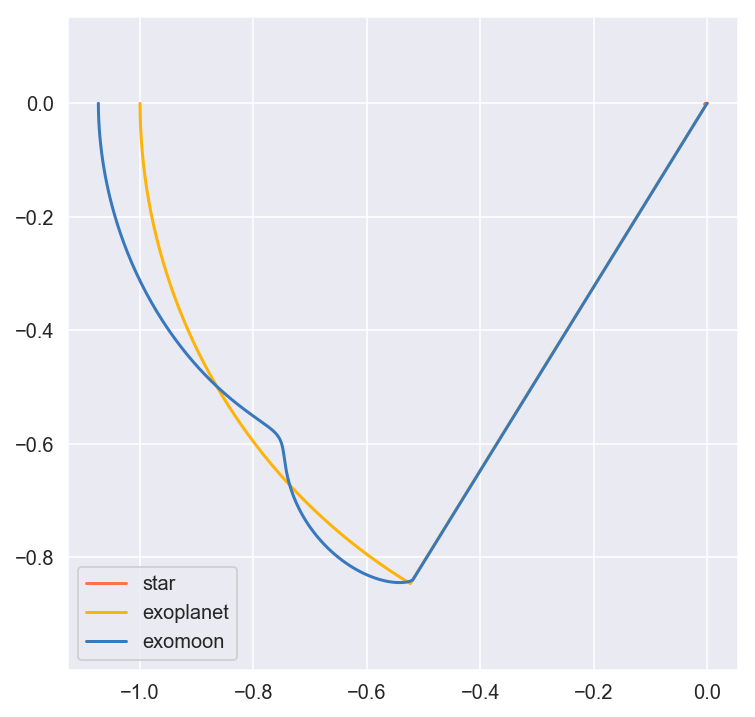

In [274]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal', 'datalim')
sns.set_color_codes('colorblind')
a_0 = np.linalg.norm(m2_coord)

c1 = sns.xkcd_palette(["pinkish orange"])[0]
c2 = sns.xkcd_palette(["amber"])[0]
c3 = sns.xkcd_palette(["windows blue"])[0]

ax.plot(X_1[:,0]/a_0, X_1[:,1]/a_0, c=c1, label='star')
ax.plot(X_2[:,0]/a_0, X_2[:,1]/a_0, c=c2, label='exoplanet')
ax.plot(X_3[:,0]/a_0, X_3[:,1]/a_0, c=c3, label='exomoon')

ax.legend()

plt.savefig('spacejam/docs/source/_static/s0.png', dpi=200, bbox_inches='tight')

### HTML

In [229]:
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize = (4,4))
ax.set_xlabel(r"$\frac{x}{a_0}$")
ax.set_ylabel(r"$\frac{y}{a_0}$")

#fig.subplots_adjust(left=0, bottom=0, right=1, top=1, 
#                    wspace=None, hspace=None)
x_1 = X_1[:, 0] / a_0
y_1 = X_1[:, 1] / a_0
x_2 = X_2[:, 0] / a_0
y_2 = X_2[:, 1] / a_0
x_3 = X_3[:, 0] / a_0
y_3 = X_3[:, 1] / a_0
margin = 0.1
lim_x_neg = np.min(np.concatenate((x_1,x_2,x_3))) - margin
lim_x_pos = np.max(np.concatenate((x_1,x_2,x_3))) + margin
lim_y_neg = np.min(np.concatenate((y_1,y_2,y_3))) - margin
lim_y_pos = np.max(np.concatenate((y_1,y_2,y_3))) + margin
nstep = int(len(x_2) / 400) # sample every n steps
x_1_downsamp = x_1[::nstep]
y_1_downsamp = y_1[::nstep]
x_2_downsamp = x_2[::nstep]
y_2_downsamp = y_2[::nstep]
x_3_downsamp = x_3[::nstep]
y_3_downsamp = y_3[::nstep]

# primary
#line0, = ax.plot([], [], lw=2) # marker
host = plt.Circle((x_1_downsamp[0], y_1_downsamp[0]), host_rad / a_0, fc=sns.xkcd_palette(["pinkish orange"])[0])
line1, = ax.plot([], [], lw=2) # trail
# secondary
secondary = plt.Circle((x_2_downsamp[-1], y_2_downsamp[-1]), scndry_rad / a_0, fc=sns.xkcd_palette(["amber"])[0])
line2, = ax.plot([], [], lw=2) # trail
#line2, = ax.plot([], [], lw=2) # marker
# companion
companion = plt.Circle((x_3_downsamp[0], y_3_downsamp[0]), cmpn_rad / a_0, fc=sns.xkcd_palette(["windows blue"])[0])
line3, = ax.plot([], [], lw=2) # trail
#line4, = ax.plot([], [], lw=2) # marker

line = [host, line1, secondary, line2, companion, line3]

ax.set_xlim(lim_x_neg, lim_x_pos)
ax.set_ylim(lim_y_neg, lim_y_pos)
ax.set_aspect("equal")

# initialization function: plot the background of each frame
def init():
    # secondary
    ax.add_patch(secondary)
    line[1].set_data([], [])
    #line[2].set_data([], [])
    # companion
    ax.add_patch(companion)
    line[3].set_data([], [])
    #line[4].set_data([], []) 
    # primary
    ax.add_patch(host)
    line[5].set_data([], [])
    #line[6].set_data([], [])
    
    return line

# animation function. This is called sequentially
def animate(i):
    # primary
    host.center = (x_1_downsamp[i], y_1_downsamp[i])
    # plot the trajectory
    line[5].set_data(x_1_downsamp[:i+1], y_1_downsamp[:i+1]) 
    line[5].set_color('w') # i+1 makes it inclusive
    # add a point at the end
    #line[6].set_data(x_1_downsamp[i], y_1_downsamp[i])
    #line[6].set_marker('X')
    #line[6].set_markersize(10)
    #line[6].set_markeredgecolor('w')
    #line[6].set_markeredgewidth(2)
    #line[6].set_color('w')
    # secondary
    secondary.center = (x_2_downsamp[i], y_2_downsamp[i])
    line[1].set_data(x_2_downsamp[:i+1], y_2_downsamp[:i+1]) # i+1 makes it inclusive
    line[1].set_color(sns.xkcd_palette(["amber"])[0])  
    # add a point at the end
    #line[2].set_data(x_2_downsamp[i], y_2_downsamp[i])
    #line[2].set_marker('o')
    #line[2].set_markersize(10)
    #line[2].set_markeredgecolor('k')
    #line[2].set_markeredgewidth(2)
    #line[2].set_color(sns.xkcd_palette(["amber"])[0])
        
    # companion
    companion.center = (x_3_downsamp[i], y_3_downsamp[i])
    # plot the trajectory
    line[3].set_data(x_3_downsamp[:i+1], y_3_downsamp[:i+1]) 
    line[3].set_color(sns.xkcd_palette(["windows blue"])[0]) # i+1 makes it inclusive
    # add a point at the end
    #line[4].set_data(x_3_downsamp[i], y_3_downsamp[i])
    #line[4].set_marker('o')
    #line[4].set_markersize(10)
    #line[4].set_markeredgecolor('k')
    #line[4].set_markeredgewidth(2)
    #line[4].set_color(sns.xkcd_palette(["windows blue"])[0])
    
    return line
plt.close() # hide static init plot

# call the animator. blit=True re-draws just the parts that have 
# changed to make things a bit faster

# remove white margin
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, 
                    wspace=None, hspace=None)
N = len(x_2_downsamp)
spf = 0.03 # seconds per frame
anim = animation.FuncAnimation(fig, animate, frames=N, init_func=init, 
                               interval = (spf * 1000), blit=True)
HTML(anim.to_html5_video())

### MP4

In [230]:
# call the animator. blit=True re-draws just the parts that have 
# changed to make things a bit faster

# remove white margin
#fig.subplots_adjust(left=0, bottom=0, right=1, top=1, 
#                    wspace=None, hspace=None)
N = len(x_2_downsamp)
spf = 0.05 # seconds per frame

FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')

# Change the video bitrate as you like and add some metadata.
mywriter = FFMpegWriter(fps=30, metadata=metadata)

anim = animation.FuncAnimation(fig, animate, frames=N, init_func=init, 
                               interval = (spf * 1000), blit=True)

anim.save("spacejam/docs/source/_static/orb.mp4", 
          writer=mywriter, dpi=500, codec=None)

MovieWriter imagemagick unavailable. Trying to use pillow instead.


# Bio Example

In [746]:
import spacejam as sj

# some useful packages for visualization
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('darkgrid')

def f(x1, x2, alpha=4., beta=4., delta=1., gamma=1.):
        f1 = alpha*x1 - beta*x1*x2
        f2 = delta*x1*x2 - gamma*x2
        return np.array([f1, f2])

# run simulation
N = 1000
h = .01 # timestep
X_0 = np.array([2., 1.]) # initial population conditions ([prey, predator])
X = np.zeros((N, X_0.size))
X[0] = X_0

for n in range(N-1):
    # s = 0
    X[n+1] = sj.integrators.amso(f, X[n], h=h, X_tol=1E-14)
    
    # s = 1
    #X[n+1] = sj.integrators.amsi(f, X[n], h=h, X_tol=1E-14)
    
    # s = 2
    #X[n+1] = sj.integrators.amsii(f, X[n], X[n-1], h=h, X_tol=1E-14)

## Viz

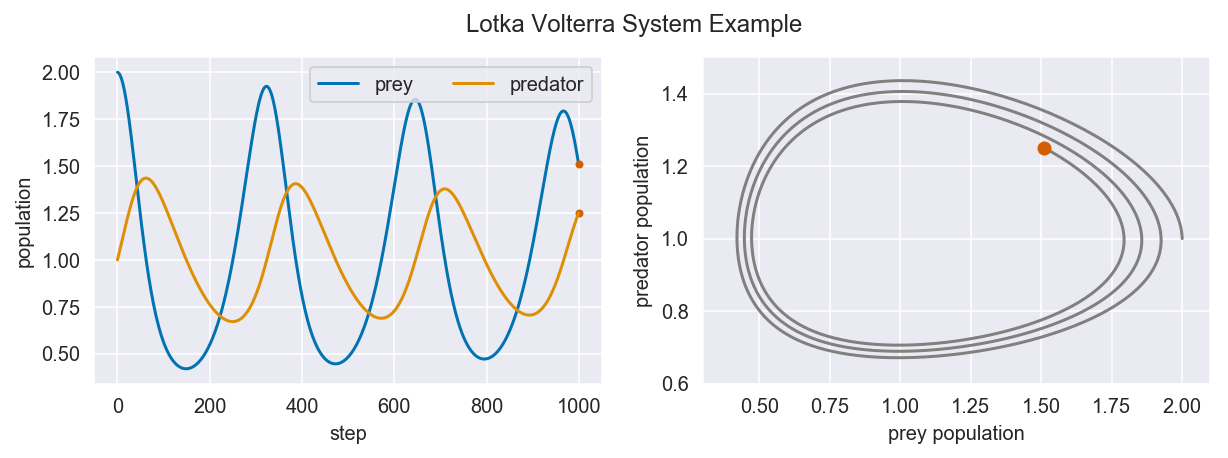

In [747]:
# plot setup
sns.set_palette('colorblind')
sns.set_color_codes('colorblind')
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
ax1, ax2 = axes

# solution plot
n = np.arange(N)
prey = X[:, 0]
pred = X[:, 1]

ax1.plot(n, prey, label='prey')
ax1.plot(n[-1], prey[-1], 'r.')
ax1.plot(n[-1], pred[-1], 'r.')
ax1.plot(n, pred, label='predator')
ax1.set_xlabel('step')
ax1.set_ylabel('population')
ax1.legend(ncol=2)

# phase plot
ax2.plot(prey, pred, c='grey')
ax2.plot(prey[-1], pred[-1], 'ro')
ax2.set_xlabel('prey population')
ax2.set_ylabel('predator population')
ax2.set_xlim(0.3, 2.1)
ax2.set_ylim(0.6, 1.5)

plt.suptitle('Lotka Volterra System Example')
plt.savefig('spacejam/docs/source/_static/lv_0.png', dpi=200, bbox_inches='tight')

### HTML5  preview

In [749]:
from matplotlib import animation
from IPython.display import HTML

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
ax1, ax2 = axes

ax1.set_xlabel('step')
ax1.set_ylabel('population')

ax2.set_xlabel('prey population')
ax2.set_ylabel('predator population')

sample = 1 # skip every (sample) points. increase for quick preview
n_sample = range(0, N, sample)
prey_sample = X[::sample, 0]
pred_sample = X[::sample, 1]

# left plot
line0, = ax1.plot(n_sample, prey_sample, label='prey') # prey trail
line1, = ax1.plot(n_sample[-1], prey_sample[-1], 'r.')
line2, = ax1.plot(n_sample, pred_sample, label='predator') # predator trail
line3, = ax1.plot(prey_sample[-1], pred_sample[-1], 'r.')
ax1.legend(ncol=2, loc=1)

# right plot
line4, = ax2.plot(prey_sample, pred_sample, c='grey') # phase trail
line5, = ax2.plot(prey[-1], pred[-1], 'ro')

def animate(i, n_sample, prey_sample, line):
    # left plot
    line0.set_data(n_sample[:i+1], prey_sample[:i+1]) # prey trail
    line1.set_data(n_sample[i], prey_sample[i])
    line2.set_data(n_sample[:i+1], pred_sample[:i+1]) # pred trail
    line3.set_data(n_sample[i], pred_sample[i])
    
    # right plot
    line4.set_data(prey_sample[:i+1], pred_sample[:i+1]) # phase trail
    line5.set_data(prey_sample[i], pred_sample[i])
    
    return line0, line1, line2, line3, line4, line5, 
plt.close()
fig.tight_layout()
anim = animation.FuncAnimation(fig, animate, len(n_sample), 
                              fargs=[n_sample, prey_sample, line],
                              interval=200, blit=True)
HTML(anim.to_html5_video())

### MP4

In [750]:
# call the animator. blit=True re-draws just the parts that have 
# changed to make things a bit faster

# remove white margin
#fig.subplots_adjust(left=0, bottom=0, right=1, top=1, 
#                    wspace=None, hspace=None)

FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')

# Change the video bitrate as you like and add some metadata.
mywriter = FFMpegWriter(fps=60, metadata=metadata)

anim.save("spacejam/docs/source/_static/lv.mp4", 
          writer=mywriter, dpi=500, codec=None)